## (a) Define the MDP

- $\mathcal{T}$ decision epochs (measured in days)
- $\mathcal{S}$ states where $s$ represents states; a tuple of number of cars at each location
- $\mathcal{A}$ actions where each action $a$ can be represented as a tuple that sums to $0$ and 
each element represents the number of cars moved in relation to the indexed location. For example $a = \{-1,0,1\}$
would represent the movement of a single car from location 1 (or more properly, location 0) to the third location.
It is assumed that one cannot move more cars from a location than exist at that location. So the valid 
actions are all $a\in\mathcal{A}_s$ for which $a+s$ is non-negative.

First, we import the supporting python libraries and enumerate the constants defined by Sutton and Barto for this problem.

In [1]:
import numpy as np
from scipy.stats import poisson
from itertools import product as cartesian_product
import matplotlib.pyplot as plt

REQUEST_LAM = [3,4]             # Poisson expectation of requests per location
RETURN_LAM  = [3,2]             # Poisson expectation of returns per location
MAX_CARS = np.array([20,20])    # length  is implicitly the number of locations
NUM_LOCATIONS = len(MAX_CARS)   # dimension of the state-space tuple
DISCOUNT = 0.9                  # \gamma
MAX_MOVE = 5
MOVE_COST = 2
OVERFLOW_COST = [4,4]
OVERNIGHT_LIM = [10,10]
RENT_CREDIT = [10,10]                # Can also be defined as an array
THETA = 1e-4

- State transition function $S^M (S_t, A_t)$
    - Will assume the parameters defined above, and provide a stochastic mapping from $S_t,A_t$ to $S_t+1$
    - For computational efficiency this function can also use an intermediate variable to calculate reward
    - Is easier to write out than transition probability

- Transition Probability Function
is a convolution of $\sim\text{poisson}(\lambda_i) \forall\lambda_i\in\Lambda$ 
where $\Lambda$ is the set of expected values in the Poisson processes that represent customer behavior
for both rental requests and returns. Each location's individual transition probability is $\sim\text{skellam}(\lambda_1,\lambda_2)$ parameterized on the expected returns and expected requests

In the case of $p(s^\prime|s)$:

In [2]:
def transition_probabilities(max_cars,req_lam,ret_lam):
    """Returns a 2D array of probabilities P[x,y] mapping
    x = future state, y = current state
    
    e.g. 
    p(x|y) : probability of future state x given current state y
    """
    num_states = max_cars+1
    states = request_range = return_range = np.arange(num_states)
    trans_probs = np.zeros([num_states]*2)

    # probability matrices x,y where given x cars on lot, y cars are rented or returned
    rental_probs = (np.tri(num_states)*poisson.pmf(request_range, req_lam) +
                    np.eye(num_states)*(1-poisson.cdf(request_range, req_lam)) )

    return_probs = (np.tri(num_states)*poisson.pmf(return_range,ret_lam) +
                    np.eye(num_states)*(1-poisson.cdf(return_range,ret_lam)) )

    # Convolve
    for current_state in states:
        for future_state in states:
            for cars_rented in range(current_state+1):

                open_spaces = max_cars - current_state + cars_rented
                cars_returned = future_state - current_state + cars_rented
                if cars_returned < 0: continue

                trans_probs[future_state,current_state] += (
                    rental_probs[current_state,cars_rented] * 
                    return_probs[open_spaces,cars_returned] )

    return trans_probs


def transition_probabilities_by_loc(location):
    args = MAX_CARS[location], REQUEST_LAM[location], RETURN_LAM[location]
    return transition_probabilities(*args)


- $r(s,a,s^\prime)$ Reward function
is the product of the cars successfully rented minus the cost of transfers made during action $a$
$$\text{credit}(s^\prime - s - a) - \text{cost}(a)$$

Next, we define an expected return function that will represent both the
$$
V(s)\leftarrow \sum_{s^\prime,r} p(s^\prime,r|s,\pi(s)) \left[r+\gamma V(s^\prime)\right]
$$
in the case of policy iteration, and
$$
V(s)\leftarrow \max_a \sum_{s^\prime,r} p(s^\prime,r|s,a) \left[r+\gamma V(s^\prime)\right]
$$
in the case of value iteration.

In [3]:
def expected_rentals(max_cars,req_lam):
    """Returns array of expected rentals indexed by the current state"""
    states = np.arange(max_cars+1)
    req_probs = poisson.pmf(states, req_lam)
    Ex = np.zeros(states.shape)

    for current_state in states:
        # p[i]: probability of renting out i cars
        rental_probs = np.append(req_probs[:current_state],
                           1-poisson.cdf(current_state-1, req_lam))
        Ex[current_state] = np.sum(states[:current_state + 1] * rental_probs)

    return Ex


def expected_rentals_by_loc(location):
    args = MAX_CARS[location],REQUEST_LAM[location]
    return expected_rentals(*args)


def expected_returns_by_state():
    expected_returns_by_loc = [fee * expected_rentals_by_loc(location) 
                               for location,fee in enumerate(RENT_CREDIT)]

    expected_returns_by_state = np.array(
        [sum(comb) for comb in cartesian_product(*expected_returns_by_loc)]
        ).reshape([len(_) for _ in expected_returns_by_loc])

    return expected_returns_by_state

def calc_discounted_expected_returns(value_function, discount=DISCOUNT):
    P1 = transition_probabilities_by_loc(location=0)
    P2 = transition_probabilities_by_loc(location=1)
    v = expected_returns_by_state() + DISCOUNT * P1.T.dot(value_function).dot(P2)
    return v

Unrelated to the MDP itself, we also define a plotting function that will provide a graphic somewhat similar to Sutton and Barto's

In [4]:
def plot_policy(policy,location=0):
    try:
        plt.imshow(policy[:,:,location], cmap='viridis', origin='lower')
    except:
        plt.imshow(policy, cmap='viridis', origin='lower')
    plt.colorbar(label='Number of cars moved from location 1 to 2')
    plt.xlabel('Number of cars at location 2')
    plt.ylabel('Number of cars at location 1')
    plt.title('Policy Grid')
    plt.show()

## (b) Dynamic Programming

In [5]:
def policy_iteration(max_iterations = 10**100, policy=None, value_function=None, 
                    extended_problem_flag=False, verbose=False, silent=False):

    # 1. Initialization
    value_function = value_function or np.zeros(np.add(MAX_CARS,1))
    policy = policy or np.zeros([*np.add(MAX_CARS,1),len(MAX_CARS)], dtype=int)

    # 2. Policy Evaluation
    policy_stable = False
    iteration = 0

    while not policy_stable and iteration < max_iterations:
        delta = 0
        edfr = calc_discounted_expected_returns(value_function)

        # a proxy for s \in S
        for state,old_value in np.ndenumerate(value_function):

            action = policy[state]
            s_prime = np.add(state,action)
            if np.greater(s_prime,MAX_CARS).any() or np.less(s_prime,0).any(): continue # Skip in invalid action
            cost = MOVE_COST * np.sum(np.abs(action))/2

            if extended_problem_flag:
                if action[0] < 0: cost -= 2 # refund on transfer cost for 1->2
                cost +=(OVERFLOW_COST*np.greater(s_prime,OVERNIGHT_LIM)).sum()
                # incur overnight fee

            value_function[*state] = edfr[*s_prime] - cost

            delta = max(delta, abs(old_value - value_function[state]))

        if delta < THETA:
                break

        # 3. Policy Improvement
        policy_stable = True

        edfr = calc_discounted_expected_returns(value_function)
        # a proxy for s \in S
        for state,old_value in np.ndenumerate(value_function):
            v_max = old_value
            a_max = policy[state]

            # ARGMAX fro action range
            for a in range(-MAX_MOVE, MAX_MOVE + 1):
                action = [-a,a]
                s_prime = np.add(state,action)
                                
                if np.greater(s_prime,MAX_CARS).any() or np.less(s_prime,0).any(): continue # Skip in invalid action
                cost = MOVE_COST * np.sum(np.abs(action))/2
                
                if extended_problem_flag:
                    if action[0] < 0: cost -= 2 # refund on transfer cost for 1->2
                    cost +=(OVERFLOW_COST*np.greater(s_prime,OVERNIGHT_LIM)).sum()
                    # incur overnight fee

                v_candidate = edfr[*s_prime] - cost
                
                if v_candidate > v_max:
                    policy_stable = False
                    v_max = v_candidate
                    a_max = action
            
            policy[state] = a_max

        if verbose:
            print("Policy Grid after iteration {}: ".format(iteration + 1))
            plot_policy(policy)
        iteration += 1

    if not silent:
        print("Policy Grid after iteration {}: ".format(iteration + 1))
        plot_policy(policy)
    return policy, value_function

Policy Grid after iteration 126: 


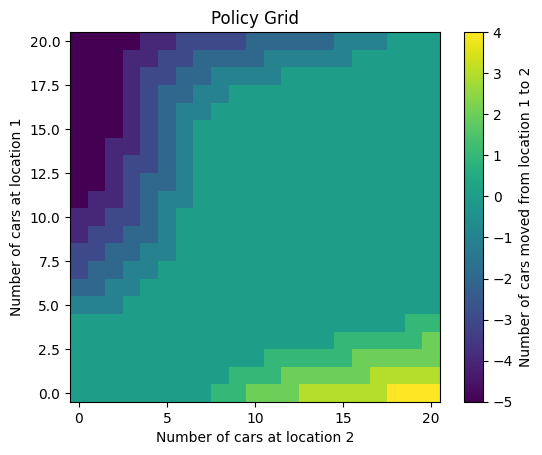

Policy Grid after iteration 126: 


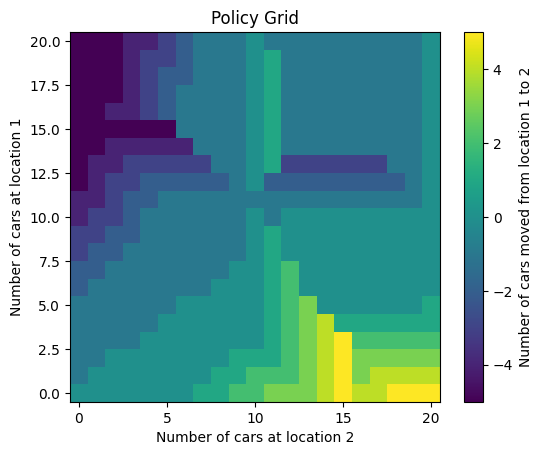

In [6]:
_,_ = policy_iteration()
_,_ = policy_iteration(extended_problem_flag=True)

## (c) Policy Insights

In the first, and vastly less efficient attempt at this the effects of the extension were a little more obvious as the scale had to be reduced significantly.

The general effect is that, Jack is far more likely make the move that occurs free of charge. This resulted in the 'banding' being a bit wider than under the original problem conditions. The 0 region seen on page 81 of Sutton and Barto's becomes far more narrow as the move 1 region in the location 1 side grows.

The overnight fee induces a behavior attempting to avoid incurring the fee. 
In certain states Jack will move cars to avoid the fee for either lot.
This can be seen in the gradient that follows the line drawn from (0,20) to (20,0).

The upper right quadrant has its own behavior as Jack is forced to accept the fee for at least one of the locations, but may be able to reallocate cars to avoid the second fee.

The new motive force can be visualized as:

<img src="Blank diagram.png" width="200">

## (d) Dynamic Programming

In [7]:
def value_iteration(max_iterations=10**100, policy=None, value_function=None, 
                    extended_problem_flag=False, verbose=False, silent=False):

    # 1. Initialization
    value_function = np.zeros(np.add(MAX_CARS, 1))
    policy = np.zeros([*np.add(MAX_CARS, 1), len(MAX_CARS)], dtype=int)

    iteration = 0
    while iteration < max_iterations:
        delta = 0
        edfr = calc_discounted_expected_returns(value_function)

        # a proxy for s \in S
        for state, old_value in np.ndenumerate(value_function):
            v_max = float('-inf')

            # Evaluate all actions and choose the one that maximizes the Q-value
            for a in range(-MAX_MOVE, MAX_MOVE + 1):
                action = [-a, a]
                s_prime = np.add(state, action)

                if np.greater(s_prime, MAX_CARS).any() or np.less(s_prime, 0).any(): continue  # Skip invalid actions
                cost = MOVE_COST * np.sum(np.abs(action)) / 2

                if extended_problem_flag:
                    if action[0] < 0: cost -= 2  # refund on transfer cost for 1->2
                    cost += (OVERFLOW_COST * np.greater(s_prime, OVERNIGHT_LIM)).sum()
                    # incur overnight fee

                v_candidate = edfr[*s_prime] - cost

                if v_candidate > v_max:
                    v_max = v_candidate
                    policy[state] = action

            value_function[*state] = v_max

            delta = max(delta, abs(old_value - value_function[state]))

        if delta < THETA:
            break

        if verbose:
            print("Policy Grid after iteration {}: ".format(iteration + 1))
            plot_policy(policy)
        iteration += 1

    if not silent:
        print("Policy Grid after iteration {}: ".format(iteration + 1))
        plot_policy(policy)
    return policy, value_function


Policy Grid after iteration 126: 


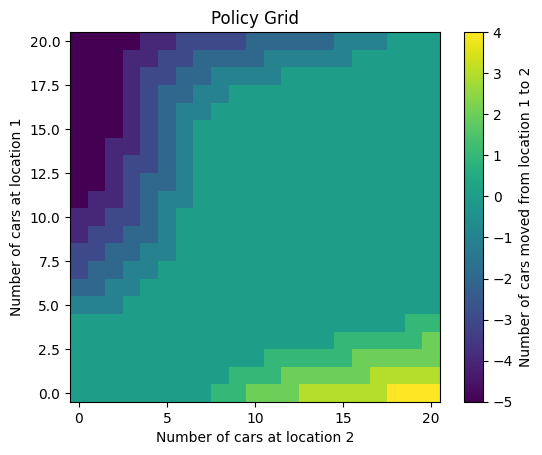

Policy Grid after iteration 126: 


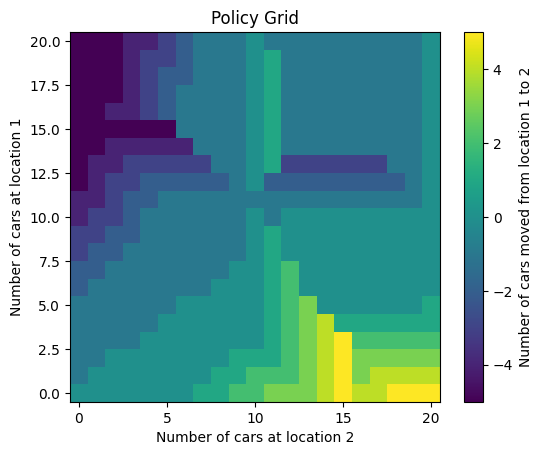

In [8]:
_,_ = value_iteration()
_,_ = value_iteration(extended_problem_flag=True)

## (e) Algorithm Comparison

In [9]:
from datetime import datetime

MAX_CARS = np.array([30,30])

start_time = datetime.now()
_,_ = policy_iteration(silent=True)
print('Duration: {}'.format(datetime.now() - start_time))

start_time = datetime.now()
_,_ = value_iteration(silent=True)
print('Duration: {}'.format(datetime.now() - start_time))


Duration: 0:00:12.911933
Duration: 0:00:10.539336


Value iteration is appears to require fewer steps. In the first iteration of homework my implementation of value iteration was less efficient and took even longer than my policy iteration implementation.

After spending time optimizing the new optimizations were amendable to a much easier conversion between policy to value iteration. The final policy that it output is the same. It appears that the intermediate policies are also quite similar if not identical.
